# tensor defination and graph

In [20]:
!pip install rustworkx

In [91]:
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

class AutogradGraph:
    __slots__ = ('graph', 'intermediate_tensors', '_check_cycles', '_auto_cleanup', '__weakref__')
    def __init__(self, check_for_cycles=True, auto_cleanup=True):

        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")


        ref = weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")

        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")

        self.intermediate_tensors[tensor._node_id] = tensor


    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return not rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def reverse_toposort_from_tensor(self, tensor_index):
        graph=self.graph
        predecessors = list(rx.ancestors(graph, tensor_index))
        predecessors.append(tensor_index)
        sub_graph = graph.subgraph(predecessors)
        return [sub_graph[i] for i in reversed(rx.topological_sort(sub_graph))]

    # def alternative_reverse_toposort_from_tensor(self, tensor_index):
    #     graph = self.graph
    #     relevant_nodes = rx.ancestors(graph, tensor_index)
    #     relevant_nodes.add(tensor_index)
    #     full_topo = rx.topological_sort(graph)
    #     relevant_topo = [graph[_node_id] for _node_id in reversed(full_topo) if _node_id in relevant_nodes]
    #     return relevant_topo

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def delete_all_non_leaf_nodes(self):
        # removes non leaf nodes from graph and clears the intermediate_tensors dict
        self.graph.remove_nodes_from(list(self.intermediate_tensors.keys()))
        self.intermediate_tensors.clear()

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__','_is_leaf')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data  # Don't rewrap
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None
        self._is_leaf = is_leaf

        if _custom_requires_grad:
            self._init_graph(graph)

    def _init_graph(self, graph):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        is_leaf=self._is_leaf
        if is_leaf:
          self.graph = weakref.proxy(graph)
        else:
          self.graph = graph # this line is only reached for tensors which are created by operations and graph passed is already a weakreference hence no need for wrapping
        graph.add_tensor_graph(self)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._add_scalar(other)#, op=torch.add)#Operations.add_tensor_and_scalar)
        elif isinstance(other, CustomTensor):
            return self._add_tensor(other)#, op=torch.add)#Operations.add_tensor_and_tensor)
        return NotImplemented

    def _add_scalar(self, scalar):
        result_tensor = torch.add(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            # print(f"Backward for scalar add: result_grad={result.tensor.grad}, self_grad_before={self_ref.tensor.grad}") # Debugging
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
            # print(f"Backward for scalar add: self_grad_after={self_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result

    def _add_tensor(self, other):
        result_tensor = torch.add(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad

        if not requires_grad:
            return CustomTensor(result_tensor)

        # Graph selection logic - assuming operations happen within a single graph context
        graph = None
        if self._custom_requires_grad:
            graph = self.graph
        elif other._custom_requires_grad:
            graph = other.graph
        else:
            # This case should ideally not be reached if requires_grad is True
            # and at least one operand has requires_grad
            pass # Or raise an error if graph is truly missing

        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)
        result_ref = weakref.proxy(result)
        def _backward():
            # print(f"Backward for tensor add: result_grad={result.tensor.grad}") # Debugging
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  self_grad_after={self_ref.tensor.grad}") # Debugging
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  other_grad_after={other_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result
    def __mul__(self, other):
        if isinstance(other, numbers.Number):
            return self._mul_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._mul_tensor(other)
        return NotImplemented

    def _mul_scalar(self, scalar):
        result_tensor = torch.mul(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad * scalar)
        result._backward = _backward
        return result

    def _mul_tensor(self, other):
        result_tensor = torch.mul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result


    def __sub__(self, other):
        if isinstance(other, numbers.Number):
            return self._sub_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._sub_tensor(other)
        return NotImplemented

    def _sub_scalar(self, scalar):
        result_tensor = torch.sub(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def _sub_tensor(self, other):
        result_tensor = torch.sub(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.sub_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def __truediv__(self, scalar):
        return self._div_scalar(scalar)

    def _div_scalar(self, scalar):
        result_tensor = torch.div(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad / scalar)
        result._backward = _backward
        return result


    def pow(self, scalar):
        result_tensor = torch.pow(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            grad_contrib = scalar * self_ref.tensor.pow(scalar - 1)
            self_ref.tensor.grad.add_(result_ref.tensor.grad * grad_contrib)
        result._backward = _backward
        return result

    def exp(self):
        out = torch.exp(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * out_tensor)

    def log(self):
        out = torch.log(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad / input_tensor)

    def sin(self):
        out = torch.sin(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad * torch.cos(input_tensor))

    def cos(self):
        out = torch.cos(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: -grad * torch.sin(input_tensor))

    def sqrt(self):
        out = torch.sqrt(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * 0.5 / out_tensor)

    def _unary_op(self, result_tensor, backward_fn):
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(backward_fn(result_ref.tensor.grad, self_ref.tensor))
        result._backward = _backward
        return result

    def matmul(self, other):
        result_tensor = torch.matmul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(torch.matmul(result_ref.tensor.grad, other_ref.tensor.t()))
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(torch.matmul(self_ref.tensor.t(), result_ref.tensor.grad))
        result._backward = _backward
        return result

    def apply_mask(self, mask):
        result_tensor = self.tensor * mask.tensor
        requires_grad = self._custom_requires_grad or mask._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else mask.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        mask_ref = weakref.proxy(mask)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if mask._custom_requires_grad:
            graph.add_edge(mask._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * mask_ref.tensor)
            if mask_ref._custom_requires_grad:
                if mask_ref.tensor.grad is None:
                    mask_ref._zero_grad()
                mask_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result

    def dot(self, other):
        result_tensor = torch.dot(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result
    def backward(self,weightage_tensor=1):
        if not self._custom_requires_grad:
            raise RuntimeError("Output tensor does not require grad.")
        if self.graph is None:
            raise RuntimeError("Output tensor is not part of a graph.")
        graph = self.graph

        # Initialize gradient for the output tensor
        if isinstance(weightage_tensor,numbers.Number):
            self.tensor.grad = torch.full_like(self.tensor, fill_value=weightage_tensor)
        elif isinstance(weightage_tensor,torch.Tensor):
            self.tensor.grad = weightage_tensor.clone() # we don't want to modify the original tensor data

        # Perform backward pass using topological sort

        nodes_to_process = graph.reverse_toposort_from_tensor(self._node_id)

        # Create a strong reference to intermediate tensors needed for backward pass
        # This simulates how a real autograd engine would keep track of them
        # The graph context's intermediate_tensors dict already serves this purpose.

        for tensor_node in nodes_to_process:
            # Check if the weak proxy is still valid (tensor is alive)
            if tensor_node.__class__ is weakref.ProxyType and tensor_node.__repr__() is None:
                # print(f"Skipping dead proxy: {tensor_node}") # Debugging
                continue # Skip if the weak reference is dead

            if tensor_node.tensor.grad is None and tensor_node is not self.tensor:
                # This can happen if a tensor is part of the graph but its grad hasn't been set yet
                # and it's not the root of the backward call. This typically means it's a leaf
                # that wasn't used to compute the output or an intermediate that accumulated no grad.
                # For simplicity in this test, we assume grads propagate.
                # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
                pass # A no-op for now. In a real system, you might want to handle this.

            # Ensure that non-leaf tensors are still alive when their _backward is called
            # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
            tensor_node._backward()

        # Clean up intermediate tensors references after backward pass
        # This would typically be handled by the graph context's exit, but
        # if `_auto_cleanup` is False, you might need manual cleanup.
        # Here, for testing GC, we'll let the context manager handle it.

        def backward_dangerous(self,weightage_tensor=1):#ONLY USE IF CALLING BACKWARD ON THE LAST NODE ADDED TO THE GRAPH AND IF YOU WANT BACKWARD ON ALL
          if not self._custom_requires_grad:
              raise RuntimeError("Output tensor does not require grad.")
          if self.graph is None:
              raise RuntimeError("Output tensor is not part of a graph.")
          graph = self.graph

          # Initialize gradient for the output tensor
          if isinstance(weightage_tensor,numbers.Number):
              self.tensor.grad = torch.full_like(self.tensor, fill_value=weightage_tensor)
          elif isinstance(weightage_tensor,torch.Tensor):
              self.tensor.grad = weightage_tensor.clone() # we don't want to modify the original tensor data

          # Perform backward pass using topological sort

          nodes_to_process = graph.reverse_toposort(self._node_id)

          # Create a strong reference to intermediate tensors needed for backward pass
          # This simulates how a real autograd engine would keep track of them
          # The graph context's intermediate_tensors dict already serves this purpose.

          for tensor_node in nodes_to_process:
              # Check if the weak proxy is still valid (tensor is alive)
              if tensor_node.__class__ is weakref.ProxyType and tensor_node.__repr__() is None:
                  # print(f"Skipping dead proxy: {tensor_node}") # Debugging
                  continue # Skip if the weak reference is dead

              if tensor_node.tensor.grad is None and tensor_node is not self.tensor:
                  # This can happen if a tensor is part of the graph but its grad hasn't been set yet
                  # and it's not the root of the backward call. This typically means it's a leaf
                  # that wasn't used to compute the output or an intermediate that accumulated no grad.
                  # For simplicity in this test, we assume grads propagate.
                  # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
                  pass # A no-op for now. In a real system, you might want to handle this.

              # Ensure that non-leaf tensors are still alive when their _backward is called
              # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
              tensor_node._backward()

          # Clean up intermediate tensors references after backward pass
          # This would typically be handled by the graph context's exit, but
          # if `_auto_cleanup` is False, you might need manual cleanup.
          # Here, for testing GC, we'll let the context manager handle it.



    def __del__(self):
      if self._node_id is not None and self._is_leaf and self.graph: #must remove leaf tensor from graph before it is deleted from memory
        # self.graph.delete_node(self._node_id)
        try:
              # Check if graph is still alive before trying to delete
              self.graph.delete_node(self._node_id)
        except ReferenceError:
              # Graph context has already been cleaned up, so do nothing.
              pass
      print(f"Garbage Collector has decided that reference counts for {self._node_id} are zero so Goodbye!!")



In [92]:
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

# AutogradGraph class remains the same as you provided
class AutogradGraph:
    __slots__ = ('graph', 'intermediate_tensors', '_check_cycles', '_auto_cleanup', '__weakref__')
    def __init__(self, check_for_cycles=True, auto_cleanup=True):
        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")

        ref = weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")
        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")
        self.intermediate_tensors[tensor._node_id] = tensor

    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return not rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def reverse_toposort_from_tensor(self, tensor_index):
        graph=self.graph
        predecessors = list(rx.ancestors(graph, tensor_index))
        predecessors.append(tensor_index)
        sub_graph = graph.subgraph(predecessors)
        return [sub_graph[i] for i in reversed(rx.topological_sort(sub_graph))]

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def delete_all_non_leaf_nodes(self):
        self.graph.remove_nodes_from(list(self.intermediate_tensors.keys()))
        self.intermediate_tensors.clear()

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__','_is_leaf')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None
        self._is_leaf = is_leaf

        if _custom_requires_grad:
            self._init_graph(graph)

    def _init_graph(self, graph):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        is_leaf=self._is_leaf
        if is_leaf:
          self.graph = weakref.proxy(graph)
        else:
          self.graph = graph
        graph.add_tensor_graph(self)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._add_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._add_tensor(other)
        return NotImplemented

    def _add_scalar(self, scalar):
        result_tensor = torch.add(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)

        result._backward = _backward
        return result

    def _add_tensor(self, other):
        result_tensor = torch.add(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        other_req_grad = other._custom_requires_grad
        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other_req_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(result_ref.tensor.grad)
                if other_req_grad and other_ref:
                    if other_ref.tensor.grad is None:
                        other_ref._zero_grad()
                    other_ref.tensor.grad.add_(result_ref.tensor.grad)

        result._backward = _backward
        return result

    def __mul__(self, other):
        if isinstance(other, numbers.Number):
            return self._mul_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._mul_tensor(other)
        return NotImplemented

    def _mul_scalar(self, scalar):
        result_tensor = torch.mul(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * scalar)
        result._backward = _backward
        return result

    def _mul_tensor(self, other):
        result_tensor = torch.mul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        other_req_grad = other._custom_requires_grad
        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other_req_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
                if other_req_grad and other_ref:
                    if other_ref.tensor.grad is None:
                        other_ref._zero_grad()
                    other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result

    def __sub__(self, other):
        if isinstance(other, numbers.Number):
            return self._sub_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._sub_tensor(other)
        return NotImplemented

    def _sub_scalar(self, scalar):
        result_tensor = torch.sub(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def _sub_tensor(self, other):
        result_tensor = torch.sub(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        other_req_grad = other._custom_requires_grad
        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other_req_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(result_ref.tensor.grad)
                if other_req_grad and other_ref:
                    if other_ref.tensor.grad is None:
                        other_ref._zero_grad()
                    other_ref.tensor.grad.sub_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def __truediv__(self, scalar):
        return self._div_scalar(scalar)

    def _div_scalar(self, scalar):
        result_tensor = torch.div(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad / scalar)
        result._backward = _backward
        return result

    def pow(self, scalar):
        result_tensor = torch.pow(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                grad_contrib = scalar * self_ref.tensor.pow(scalar - 1)
                self_ref.tensor.grad.add_(result_ref.tensor.grad * grad_contrib)
        result._backward = _backward
        return result

    def exp(self):
        out = torch.exp(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * out_tensor)

    def log(self):
        out = torch.log(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad / input_tensor)

    def sin(self):
        out = torch.sin(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad * torch.cos(input_tensor))

    def cos(self):
        out = torch.cos(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: -grad * torch.sin(input_tensor))

    def sqrt(self):
        out = torch.sqrt(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * 0.5 / out_tensor)

    def _unary_op(self, result_tensor, backward_fn):
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref and result_ref:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(backward_fn(result_ref.tensor.grad, self_ref.tensor))
        result._backward = _backward
        return result

    def matmul(self, other):
        result_tensor = torch.matmul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        other_req_grad = other._custom_requires_grad
        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other_req_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(torch.matmul(result_ref.tensor.grad, other_ref.tensor.t()))
                if other_req_grad and other_ref:
                    if other_ref.tensor.grad is None:
                        other_ref._zero_grad()
                    other_ref.tensor.grad.add_(torch.matmul(self_ref.tensor.t(), result_ref.tensor.grad))
        result._backward = _backward
        return result

    def apply_mask(self, mask):
        result_tensor = self.tensor * mask.tensor
        requires_grad = self._custom_requires_grad or mask._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else mask.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        mask_req_grad = mask._custom_requires_grad
        self_ref = weakref.proxy(self)
        mask_ref = weakref.proxy(mask)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if mask_req_grad:
            graph.add_edge(mask._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(result_ref.tensor.grad * mask_ref.tensor)
                if mask_req_grad and mask_ref:
                    if mask_ref.tensor.grad is None:
                        mask_ref._zero_grad()
                    mask_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result

    def dot(self, other):
        result_tensor = torch.dot(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_req_grad = self._custom_requires_grad
        other_req_grad = other._custom_requires_grad
        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self_req_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other_req_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if result_ref:
                if self_req_grad and self_ref:
                    if self_ref.tensor.grad is None:
                        self_ref._zero_grad()
                    self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
                if other_req_grad and other_ref:
                    if other_ref.tensor.grad is None:
                        other_ref._zero_grad()
                    other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result

    def backward(self, weightage_tensor=1):
        if not self._custom_requires_grad:
            raise RuntimeError("Output tensor does not require grad.")
        if self.graph is None:
            raise RuntimeError("Output tensor is not part of a graph.")
        graph = self.graph

        if isinstance(weightage_tensor, numbers.Number):
            self.tensor.grad = torch.full_like(self.tensor, fill_value=weightage_tensor)
        elif isinstance(weightage_tensor, torch.Tensor):
            self.tensor.grad = weightage_tensor.clone()

        nodes_to_process = graph.reverse_toposort_from_tensor(self._node_id)

        for tensor_node in nodes_to_process:
            try:
                # This will raise a ReferenceError if the proxy is dead
                if tensor_node.__class__ is weakref.ProxyType and tensor_node.__repr__() is None:
                    continue
                tensor_node._backward()
            except ReferenceError:
                # This catches dead weak references, allowing the process to continue
                continue



    def __del__(self):
      if self._node_id is not None and self._is_leaf:
          #self.graph.delete_node(self._node_id)
          try:
              # Check if graph is still alive before trying to delete
              self.graph.delete_node(self._node_id)
          except ReferenceError:
              # Graph context has already been cleaned up, so do nothing.
              pass
      print(f"Garbage Collector has decided that reference counts for node {self._node_id} are zero so Goodbye!!")

In [37]:
import sys
import gc
class TestCustomAutogradSystem:

    def test_basic_add_scalar_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 5.0 # (a + 5)
            c = b + 10.0 # (a + 5 + 10)

            # Manually run backward pass
            c.backward(weightage_tensor=1)

            # Expected gradients:
            # dC/dA = 1.0 (for each element)
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is not None
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0])) # dC/dB = 1.0

            # Verify graph structure
            assert graph.graph.num_nodes() == 3
            assert graph.graph.num_edges() == 2
            assert graph.graph.has_edge(a._node_id, b._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.check_cycle() is False

    def test_basic_add_tensor_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            c = a + b # (a + b)
            d = c + 5.0 # (a + b + 5)

            d.backward(weightage_tensor=1)

            # Expected gradients:
            # dD/dA = 1.0
            # dD/dB = 1.0
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0]))

            # Verify graph structure
            assert graph.graph.num_nodes() == 4
            assert graph.graph.num_edges() == 3
            assert graph.graph.has_edge(a._node_id, c._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.graph.has_edge(c._node_id, d._node_id)
            assert graph.check_cycle() is False

    def test_mixed_requires_grad_tensor_add(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=False) # Does not require grad
            c = a + b # c should require grad, b's grad should be None

            c.backward(weightage_tensor=1)

            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is None # b should not have a grad
            assert c._custom_requires_grad is True

            # Verify graph structure
            assert graph.graph.num_nodes() == 2 # Only a and c in the graph
            assert graph.graph.num_edges() == 1
            assert graph.graph.has_node(a._node_id)
            assert graph.graph.has_node(c._node_id)
            assert graph.graph.has_edge(a._node_id, c._node_id)
            #assert not graph.graph.has_node(b._node_id) # b should not be in graph

    def test_no_requires_grad(self):
        with AutogradGraph() as graph: # Graph created, but no tensors with requires_grad=True added
            a = CustomTensor(torch.tensor([1.0]))
            b = CustomTensor(torch.tensor([2.0]))
            c = a + b
            d = c + 3.0

            assert not a._custom_requires_grad
            assert not b._custom_requires_grad
            assert not c._custom_requires_grad
            assert not d._custom_requires_grad
            assert graph.graph.num_nodes() == 0 # Graph should remain empty
            assert graph.graph.num_edges() == 0

            with pytest.raises(RuntimeError, match="Output tensor does not require grad."):
                d.backward(weightage_tensor=1)

    def test_autograd_graph_context_manager(self):
        graph = None
        with AutogradGraph(check_for_cycles=True, auto_cleanup=True) as g:
            graph = g
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 1.0
            assert graph.graph.num_nodes() == 2
            assert graph.graph.num_edges() == 1
            assert len(graph.intermediate_tensors) == 1 # b should be in intermediate_tensors

        # After exiting the context, graph should be empty
        assert graph.graph.num_nodes() == 0
        assert graph.graph.num_edges() == 0
        assert len(graph.intermediate_tensors) == 0

    def test_cycle_detection(self):
      try:
        with AutogradGraph(check_for_cycles=True, auto_cleanup=False) as graph: # auto_cleanup=False to inspect after error
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)

            # Manually create a cycle (a -> b -> a)
            graph.add_edge(a._node_id, b._node_id)
            graph.add_edge(b._node_id, a._node_id)
      except RuntimeError as e:
        print(f"Raised the error of cycle detected as {e}")
            # with pytest.raises(RuntimeError, match="Cycle detected in autograd graph on context exit."):
            #     pass # The __exit__ method will be called here

    def test_no_circular_references_non_leaf_tensors_die(self):
          # This test relies on the garbage collector. It's a heuristic test
        # as Python's GC timing is not strictly deterministic.
        # However, with weakrefs, it should work for non-leaf tensors.

      print("\n--- Starting GC Test: No Circular References (Part 1) ---")

      graph_ref = None
      output_tensor_weak_ref = None
      node_id_d = -1 # To store node_id before d is deleted

      # BLOCK 1: Create graph and tensors
      with AutogradGraph(auto_cleanup=False) as graph: # Keep graph for inspection
          graph_ref = weakref.ref(graph)
          a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
          b = a + 1.0 # Intermediate tensor
          c = b + 2.0 # Intermediate tensor
          d = c + 3.0 # Output tensor (also intermediate from graph's perspective)

          # Store weak reference to 'd' BEFORE its strong reference is potentially removed
          output_tensor_weak_ref = weakref.ref(d)
          node_id_d = d._node_id # Store node_id while d is alive

          print(f"Initial: d object: {d}")
          print(f"Initial: d._node_id: {node_id_d}")
          print(f"Initial: graph.intermediate_tensors keys: {list(graph.intermediate_tensors.keys())}")
          # The ref count for `d` object itself will be high here because it's in `graph.intermediate_tensors`,
          # and held by variable `d`, and by the temporary ref in `getrefcount`.
          print(f"Initial: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'}")
          assert len(graph.intermediate_tensors) == 3 # b, c, d should be in intermediate_tensors

      # BLOCK 2: After exiting context manager (auto_cleanup=False)
      print("\n--- After exiting 'with' block (auto_cleanup=False) ---")
      # The 'graph' variable still holds a strong reference to the AutogradGraph instance.
      # graph_ref() should return the graph object.
      assert graph_ref() is not None, "Graph object should still be alive."
      assert len(graph_ref().intermediate_tensors) == 3, "Intermediate tensors should still be referenced by the graph."
      print(f"After 'with' block: d object (via weakref): {output_tensor_weak_ref()}")
      print(f"After 'with' block: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref())}")

      # BLOCK 3: Remove strong reference 'd' from local scope
      print("\n--- Deleting 'd' variable ---")
      del d # Remove the local strong reference to the CustomTensor object.
      gc.collect() # Force garbage collection

      # Now, output_tensor_weak_ref() *still* shouldn't be None because `graph_ref().intermediate_tensors`
      # holds the strong reference.
      print(f"After del d + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # We expect this to *not* be None yet, and to still show a refcount reflecting intermediate_tensors.
      assert output_tensor_weak_ref() is not None, "d should still be alive due to intermediate_tensors."
      current_d_refcount_after_del_d = sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'
      print(f"After del d + gc.collect(): refcount of d: {current_d_refcount_after_del_d}")
      # Expected refcount should be 2: one from intermediate_tensors, one from getrefcount()
      assert current_d_refcount_after_del_d == 2, f"Expected refcount 2, got {current_d_refcount_after_del_d}"

      # BLOCK 4: Remove strong reference from intermediate_tensors
      print(f"\n--- Deleting strong reference from graph.intermediate_tensors for node {node_id_d} ---")
      graph_ref().del_non_leaf_tensor_reference(node_id_d) # THIS IS THE CRUCIAL STEP
      print(f"After del_non_leaf_tensor_reference: graph.intermediate_tensors keys: {list(graph_ref().intermediate_tensors.keys())}")
      #gc.collect() # Force garbage collection again

      # Now, with the last strong reference gone, 'd' should be garbage collected.
      print(f"After del_non_leaf_tensor_reference + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # This is where your original assertion was. It *should* pass now.
      assert output_tensor_weak_ref() is None, "Output tensor (non-leaf) should be garbage collected after its strong reference is deleted from intermediate_tensors."
      print("Assertion Passed: Output tensor (d) was garbage collected.")

      # BLOCK 5: Verify other intermediate tensors are collected when graph is cleared
      print("\n--- Starting GC Test: All Intermediate Tensors ---")
      intermediate_tensors_wrefs = []
      # Create a new graph and new tensors to avoid interference from previous block
      with AutogradGraph(auto_cleanup=False) as graph_new:
          a_new = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph_new, is_leaf=True)
          b_new = a_new + 1.0 # Intermediate
          c_new = b_new + 2.0 # Intermediate
          d_new = c_new + 3.0 # Intermediate (output of a chain)

          # Store weak references to the intermediate tensors
          intermediate_tensors_wrefs.append(weakref.ref(b_new))
          intermediate_tensors_wrefs.append(weakref.ref(c_new))
          intermediate_tensors_wrefs.append(weakref.ref(d_new))

          # Verify they are initially alive
          assert all(wref() is not None for wref in intermediate_tensors_wrefs)
          assert len(graph_new.intermediate_tensors) == 3

      print(f"After 'with' block (new graph): graph_new object: {graph_new}")
      assert graph_new is not None, "New graph object should still be alive after 'with' block."
      assert len(graph_new.intermediate_tensors) == 3, "New graph intermediate_tensors should still hold refs."

      # Manually clear the intermediate_tensors dictionary and remove graph reference
      print("\n--- Manually clearing graph.intermediate_tensors and deleting graph ---")
      graph_new.intermediate_tensors.clear()
      del graph_new # Remove the strong reference to the graph itself
      del b_new , c_new , d_new # deleting the local variable strong references
      #gc.collect()

      # Now, all non-leaf tensors should be garbage collected
      for i, wref in enumerate(intermediate_tensors_wrefs):
          print(f"Intermediate tensor {i} (via weakref): {wref()}")
          assert wref() is None, f"Intermediate tensor {i} should be garbage collected after graph context and intermediate_tensors are cleared."
      print("Assertion Passed: All intermediate tensors were garbage collected.")

    def test_topological_sort_order(self):
        with AutogradGraph() as graph:
            t1 = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t2 = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t3 = t1 + t2
            t4 = t3 + 5.0
            t5 = t2 + 10.0 # Another branch
            t6 = t4 + t5

            # The topological sort should produce an order where dependencies come before their dependents.
            # Reversed topological sort should produce an order where outputs come before their inputs.
            # Example expected order: t6, t4, t5, t3, t2, t1 (or variations respecting dependencies)
            sorted_tensors = graph.reverse_toposort()

            # Check if dependencies are respected in reverse order
            # If A -> B, then B should appear before A in reverse topological sort.
            # t6 depends on t4, t5. So t6 should be before t4 and t5.
            # t4 depends on t3. So t4 should be before t3.
            # t5 depends on t2. So t5 should be before t2.
            # t3 depends on t1, t2. So t3 should be before t1 and t2.

            # Simple check: The first element should be t6 (the ultimate output).
            assert sorted_tensors[0] is t6

            # Check positions:
            pos = {t: i for i, t in enumerate(sorted_tensors)}

            assert pos[t6] < pos[t4]
            assert pos[t6] < pos[t5]
            assert pos[t4] < pos[t3]
            assert pos[t5] < pos[t2]
            assert pos[t3] < pos[t1]
            assert pos[t3] < pos[t2] # t3 also depends on t2

            # Additional check: t2 is a dependency for both t3 and t5.
            # In reverse topo sort, t3 and t5 must appear before t2.
            assert pos[t3] < pos[t2]
            assert pos[t5] < pos[t2]

            # t1 is only a dependency for t3.
            assert pos[t3] < pos[t1]

            # Check if all 6 tensors are in the sorted list
            assert len(sorted_tensors) == 6
            assert set(sorted_tensors) == {t1, t2, t3, t4, t5, t6}

In [38]:
import torch
import numpy as np
import numbers
import weakref
import rustworkx as rx
from typing import Optional, Any


class AutogradTester:
    """Test suite to verify custom autograd against PyTorch's autograd"""

    def __init__(self):
        self.passed_tests = 0
        self.failed_tests = 0
        self.tolerance = 1e-6

    def assert_tensors_close(self, custom_tensor, pytorch_tensor, test_name, check_grad=True):
        """Compare custom tensor with PyTorch tensor"""
        try:
            # Check values
            np.testing.assert_allclose(
                custom_tensor.tensor.detach().numpy(),
                pytorch_tensor.detach().numpy(),
                rtol=self.tolerance,
                atol=self.tolerance
            )

            # Check gradients if requested
            if check_grad and pytorch_tensor.grad is not None:
                if custom_tensor.tensor.grad is None:
                    raise AssertionError(f"Custom tensor has no gradient in {test_name}")

                np.testing.assert_allclose(
                    custom_tensor.tensor.grad.detach().numpy(),
                    pytorch_tensor.grad.detach().numpy(),
                    rtol=self.tolerance,
                    atol=self.tolerance
                )

            print(f"✓ {test_name}")
            self.passed_tests += 1

        except Exception as e:
            print(f"✗ {test_name}: {str(e)}")
            self.failed_tests += 1

    def test_basic_operations(self):
        """Test basic arithmetic operations"""
        print("\n=== Testing Basic Operations ===")

        with AutogradGraph() as graph:
            # Test scalar addition
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom + 5.0
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = x_pytorch + 5.0
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Addition")
            self.assert_tensors_close(y_custom, y_pytorch, "Scalar Addition Result", check_grad=False)

        with AutogradGraph() as graph:
            # Test tensor addition
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom + y_custom
            z_custom.backward(torch.ones_like(z_custom.tensor))

            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.tensor([3.0, 4.0], requires_grad=True)
            z_pytorch = x_pytorch + y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Tensor Addition - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Tensor Addition - y")

    def test_multiplication(self):
        """Test multiplication operations"""
        print("\n=== Testing Multiplication ===")

        with AutogradGraph() as graph:
            # Test scalar multiplication
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom * 4.0
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = x_pytorch * 4.0
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Multiplication")

        with AutogradGraph() as graph:
            # Test tensor multiplication
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom * y_custom
            z_custom.backward(torch.ones_like(z_custom.tensor))

            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0], requires_grad=True)
            z_pytorch = x_pytorch * y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Tensor Multiplication - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Tensor Multiplication - y")

    def test_subtraction_division(self):
        """Test subtraction and division"""
        print("\n=== Testing Subtraction and Division ===")

        with AutogradGraph() as graph:
            # Test subtraction
            x_custom = CustomTensor([5.0, 6.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom - 2.0
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([5.0, 6.0], requires_grad=True)
            y_pytorch = x_pytorch - 2.0
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Subtraction")

        with AutogradGraph() as graph:
            # Test division
            x_custom = CustomTensor([8.0, 12.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom / 4.0
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([8.0, 12.0], requires_grad=True)
            y_pytorch = x_pytorch / 4.0
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Division")

    def test_power_function(self):
        """Test power operation"""
        print("\n=== Testing Power Function ===")

        with AutogradGraph() as graph:
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.pow(3.0)
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.pow(x_pytorch, 3.0)
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Power Function")

    def test_unary_functions(self):
        """Test unary mathematical functions"""
        print("\n=== Testing Unary Functions ===")

        # Test exp
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.exp()
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.exp(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Exponential Function")

        # Test log
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.log()
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.log(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Logarithm Function")

        # Test sin
        with AutogradGraph() as graph:
            x_custom = CustomTensor([0.5, 1.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.sin()
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([0.5, 1.0], requires_grad=True)
            y_pytorch = torch.sin(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Sine Function")

        # Test sqrt
        with AutogradGraph() as graph:
            x_custom = CustomTensor([4.0, 9.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.sqrt()
            y_custom.backward(torch.ones_like(y_custom.tensor))

            x_pytorch = torch.tensor([4.0, 9.0], requires_grad=True)
            y_pytorch = torch.sqrt(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Square Root Function")

    def test_matrix_operations(self):
        """Test matrix operations"""
        print("\n=== Testing Matrix Operations ===")

        # Test matrix multiplication
        with AutogradGraph() as graph:
            x_custom = CustomTensor([[1.0, 2.0], [3.0, 4.0]], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([[5.0, 6.0], [7.0, 8.0]], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom.matmul(y_custom)
            z_custom.backward(torch.ones_like(z_custom.tensor))

            x_pytorch = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
            y_pytorch = torch.tensor([[5.0, 6.0], [7.0, 8.0]], requires_grad=True)
            z_pytorch = torch.matmul(x_pytorch, y_pytorch)
            z_pytorch.backward(torch.ones_like(z_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Matrix Multiplication - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Matrix Multiplication - y")

        # Test dot product
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0, 6.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom.dot(y_custom)
            z_custom.backward()

            x_pytorch = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0, 6.0], requires_grad=True)
            z_pytorch = torch.dot(x_pytorch, y_pytorch)
            z_pytorch.backward()

            self.assert_tensors_close(x_custom, x_pytorch, "Dot Product - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Dot Product - y")

    def test_complex_chain(self):
        """Test complex computational chains"""
        print("\n=== Testing Complex Chains ===")

        with AutogradGraph() as graph:
            # Test: z = (x + y) * (x - y) + x^2
            x_custom = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)

            sum_custom = x_custom + y_custom
            diff_custom = x_custom - y_custom
            prod_custom = sum_custom * diff_custom
            x_squared_custom = x_custom.pow(2.0)
            z_custom = prod_custom + x_squared_custom

            z_custom.backward(torch.ones_like(z_custom.tensor))

            x_pytorch = torch.tensor([3.0, 4.0], requires_grad=True)
            y_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)

            sum_pytorch = x_pytorch + y_pytorch
            diff_pytorch = x_pytorch - y_pytorch
            prod_pytorch = sum_pytorch * diff_pytorch
            x_squared_pytorch = torch.pow(x_pytorch, 2.0)
            z_pytorch = prod_pytorch + x_squared_pytorch

            z_pytorch.backward(torch.ones_like(z_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Complex Chain - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Complex Chain - y")

    def test_mixed_operations(self):
        """Test mixing operations with and without gradients"""
        print("\n=== Testing Mixed Operations ===")

        with AutogradGraph() as graph:
            # One tensor requires grad, other doesn't
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0])  # No grad
            z_custom = x_custom * y_custom
            z_custom.backward(torch.ones_like(z_custom.tensor))

            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0])  # No grad
            z_pytorch = x_pytorch * y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))

            self.assert_tensors_close(x_custom, x_pytorch, "Mixed Operations - x")

    def run_all_tests(self):
        """Run all tests"""
        print("Running Custom Autograd Correctness Tests")
        print("=" * 50)

        self.test_basic_operations()
        self.test_multiplication()
        self.test_subtraction_division()
        self.test_power_function()
        self.test_unary_functions()
        self.test_matrix_operations()
        self.test_complex_chain()
        self.test_mixed_operations()

        print(f"\n" + "=" * 50)
        print(f"Test Results: {self.passed_tests} passed, {self.failed_tests} failed")

        if self.failed_tests == 0:
            print("🎉 All tests passed! Your autograd implementation is correct.")
        else:
            print("❌ Some tests failed. Check the implementation.")

        return self.failed_tests == 0



# Testing

In [52]:
import time

In [93]:
# import gc
with AutogradGraph() as graph:
  with torch.no_grad():
    x=CustomTensor([1,2,3],_custom_requires_grad=True,is_leaf=True,graph=graph)
    y=CustomTensor([4,5,6],_custom_requires_grad=True,is_leaf=True,graph=graph)
    z=x+y
    x=5+5
    y=5+5
    #z=None
    #gc.collect()
  # z.backward(torch.ones_like(z.tensor))

# time.sleep(2)

Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!


In [45]:
import gc
import weakref

with AutogradGraph() as graph:
    with torch.no_grad():
        x = CustomTensor([1,2,3], _custom_requires_grad=True, is_leaf=True, graph=graph)
        y = CustomTensor([4,5,6], _custom_requires_grad=True, is_leaf=True, graph=graph)

        # Create weak references to track them
        x_weak = weakref.ref(x)
        y_weak = weakref.ref(y)

        z = x + y
        x = 5 + 5
        y = 5 + 5

        print(f"Before gc.collect(): x alive: {x_weak() is not None}, y alive: {y_weak() is not None}")
        gc.collect()
        print(f"After gc.collect(): x alive: {x_weak() is not None}, y alive: {y_weak() is not None}")

Before gc.collect(): x alive: True, y alive: True
After gc.collect(): x alive: True, y alive: True


10

In [35]:
z.tensor

tensor([5, 7, 9])

In [6]:
import sys

In [15]:
sys.getrefcount(y)

4

In [45]:
del x,y

In [94]:
k=TestCustomAutogradSystem()
k.test_basic_add_scalar_grad()
k.test_basic_add_tensor_grad()
k.test_mixed_requires_grad_tensor_add()
k.test_no_requires_grad()
k.test_autograd_graph_context_manager()
k.test_cycle_detection()
k.test_no_circular_references_non_leaf_tensors_die()
k.test_cycle_detection()

Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 2 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 2 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 3 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node None are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node None are zero so Goodbye!!
Garbage Collector has decided that reference counts for nod

In [97]:
# Usage example:
if __name__ == "__main__":
    # Insert your AutogradGraph and CustomTensor classes here
    # Then run the tests

    tester = AutogradTester()
    success = tester.run_all_tests()

    # Additional manual verification
    print("\n" + "=" * 50)
    print("Manual Verification Example:")

    with AutogradGraph() as graph:
        x = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
        y = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)

        # Compute z = x^2 + 2*x*y + y^2 = (x + y)^2
        z = x.pow(2.0) + (x * y * 2.0) + y.pow(2.0)
        print(f"z = {z.tensor}")

        # Backward pass
        z.backward(torch.ones_like(z.tensor))

        print(f"dz/dx = {x.tensor.grad}")  # Should be 2*(x + y)
        print(f"dz/dy = {y.tensor.grad}")  # Should be 2*(x + y)

        # Expected: dz/dx = dz/dy = 2*(x + y) = 2*[4, 6] = [8, 12]
        expected_grad = 2 * (x.tensor + y.tensor)
        print(f"Expected gradient: {expected_grad}")

Running Custom Autograd Correctness Tests

=== Testing Basic Operations ===
✓ Scalar Addition
✓ Scalar Addition Result
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
✓ Tensor Addition - x
✓ Tensor Addition - y
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 2 are zero so Goodbye!!

=== Testing Multiplication ===
✓ Scalar Multiplication
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference counts for node 1 are zero so Goodbye!!
✓ Tensor Multiplication - x
✓ Tensor Multiplication - y
Garbage Collector has decided that reference counts for node 0 are zero so Goodbye!!
Garbage Collector has decided that reference 

In [2]:
import torch

In [9]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

z = x + y       # z = x + y
x = z * y       # x is reassigned (detached from old x)
e = z + x + y   # e depends on new x (which is z*y)
e.backward(retain_graph=True)    # Computes gradients for y (old x is gone)
print(y.grad)
e.backward()    # Accumulates gradients again (for y only)

tensor(7.)


In [5]:
y.grad

tensor(14.)

In [14]:
del x,y

In [15]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

for _ in range(2):
    z = x + y       # z = x + y
    x = z * y       # x is reassigned (detached)
    e = z + x + y   # e depends on new x
    e.backward(retain_graph=True)    # Gradients computed per iteration

In [16]:
y.grad

tensor(34.)

In [18]:
import torch

# Case 1: Multiple e.backward() calls
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

z = x + y
x_reassigned = z * y # This creates a new tensor, x now points to it
e = z + x_reassigned + y

e.backward(retain_graph=True)
print(f"Case 1 - First backward, y.grad: {y.grad.item()}") # Should be 7.0
e.backward()
print(f"Case 1 - Second backward, y.grad: {y.grad.item()}") # Should be 14.0



Case 1 - First backward, y.grad: 7.0
Case 1 - Second backward, y.grad: 14.0

Loop Iteration 1
y.grad after iteration 1: 7.0

Loop Iteration 2
y.grad after iteration 2: 34.0


In [3]:
!pip install torchviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [35]:
from torchviz import make_dot
import torch

In [4]:
del x,y

In [7]:

# Reset gradients for comparison
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

# Case 2: In a loop
for i in range(2):
    print(f"\nLoop Iteration {i+1}")
    # z depends on the *current* x and y
    z = x + y
    # x is reassigned to a *new* tensor resulting from z*y
    x = z * y
    e = z + x + y
    print(f"x: {x.item()}, y: {y.item()}, z: {z.item()}, e: {e.item()}")
    e.backward(retain_graph=True) # Retain graph for all but the last iteration if needed
    make_dot(e, params={'x': x, 'y': y}).render(f"autograd_graph_iter_{i}", format="png")
    print(f"y.grad after iteration {i+1}: {y.grad.item()}")



Loop Iteration 1
x: 6.0, y: 2.0, z: 3.0, e: 11.0
y.grad after iteration 1: 7.0

Loop Iteration 2
x: 16.0, y: 2.0, z: 8.0, e: 26.0
y.grad after iteration 2: 34.0


In [8]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
t1 =x+y
t2=t1*y
t3=t2+y
t4= t3*y
t5 = t4+t3
t6 = t5+y
e=t6
e.backward()

In [ ]:
def count_nodes(node):
    count = 0
    if node is not None:
        count += 1
        for next_node, _ in node.next_functions:
            count += count_nodes(next_node)
    return count

In [9]:
y.grad

tensor(27.)

In [25]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z1=x+y
x1 = z1*y
e1 = z1+y+x1
z2=x1+y
x2 = z2*y
e2=z2+x2+y
print(e2.item())
e2.backward()

26.0


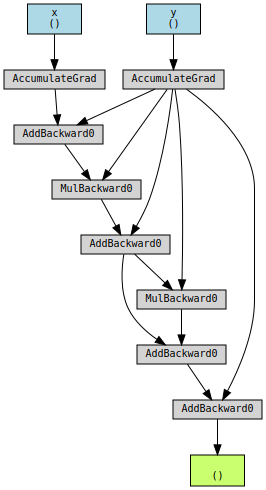

In [26]:
make_dot(e2, params={'x': x, 'y': y})

In [16]:
y.grad

tensor(27.)

In [34]:
%reset -f

In [20]:

# Reset gradients for comparison
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

# Case 2: In a loop
for i in range(2):
    print(f"\nLoop Iteration {i+1}")
    # z depends on the *current* x and y
    z = x + y
    # x is reassigned to a *new* tensor resulting from z*y
    x = z * y
    e = z + x + y
    print(f"x: {x.item()}, y: {y.item()}, z: {z.item()}, e: {e.item()}")
    #e.backward(retain_graph=True) # Retain graph for all but the last iteration if needed
    #make_dot(e, params={'x': x, 'y': y}).render(f"autograd_graph_iter_{i}", format="png")



Loop Iteration 1
x: 6.0, y: 2.0, z: 3.0, e: 11.0

Loop Iteration 2
x: 16.0, y: 2.0, z: 8.0, e: 26.0


In [26]:
if False:
  print("478920")

In [21]:
e.backward()

In [16]:
!pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 669.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [20]:
%reset -f
import torch
import torch.autograd.graph as ag
from torchviz import make_dot

In [65]:
ag.save_on_cpu(True)

In [21]:
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
z1=x+y
x1 = z1*y
e1 = z1+y+x1
z2=x1+y
x2 = z2*y
e2=z2+x2+y

In [18]:

x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)
t1 =x+y
t2=t1*y
t3=t2+y
t4= t3*y
t5 = t4+t3
t6 = t5+y
e=t6
# e.backward()

In [22]:
def count_nodes(node):
    count = 0
    if node is not None:
        count += 1
        for next_node, _ in node.next_functions:
            count += count_nodes(next_node)
    return count

In [24]:
count_nodes(e2.grad_fn)

19

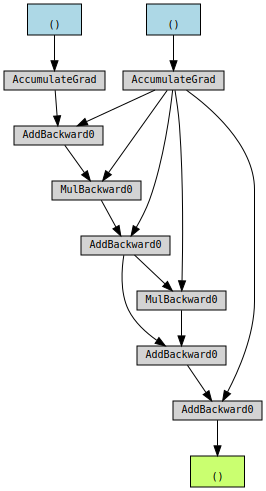

In [19]:
make_dot(e)

In [70]:
ag.save_on_cpu(False)

In [33]:
import torch
import torch.autograd.graph as ag

# Enable graph debugging
ag.save_on_cpu(True) # This saves data needed for visualization on CPU

x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(2.0, requires_grad=True)

z1 = x + y
x1 = z1 * y
e1 = z1 + y + x1 # Let's stop here for a simpler graph to visualize.

# You can access the grad_fn of the final tensor
print(e1.grad_fn)

# To visualize the graph (requires graphviz installed and dot in PATH)
# dot_graph = ag.make_dot(e1, params={'x': x, 'y': y})
# dot_graph.render("computation_graph", view=True) # Saves as PDF and opens

# You can also iterate through the graph (less straightforward for simple count)
def count_nodes(node):
    count = 0
    if node is not None:
        count += 1
        for next_node, _ in node.next_functions:
            count += count_nodes(next_node)
    return count

# This counts the grad_fn nodes, not the tensors directly
print(f"Number of grad_fn nodes: {count_nodes(e1.grad_fn)}")

ag.save_on_cpu(False) # Disable debugging after use

Number of grad_fn nodes: 11


In [25]:
import torch
x = torch.tensor(1.0, requires_grad=True)
y = x * 2
y.backward()
grad = x.grad  # grad now references the gradient tensor
del x          # x is deallocated, but grad still holds a reference
print(grad)    # Outputs tensor(2.0), as grad persists

tensor(2.)
